**Importing all the necessary Libraries for the task**

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer

Importing the data file in CSV format, Starting part of the Preprocessing phase(the other part was done using MS Excel)

In [2]:
#the variable data_ad holds the dataframe for Adamawa state data
cross_river = pd.read_csv('data_cross_river.csv')
print(cross_river.shape)

(22, 12)


In [3]:
cross_river.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           22 non-null     int64  
 1   s_pressure     22 non-null     float64
 2   av_temp        22 non-null     float64
 3   sp_humidity    22 non-null     float64
 4   re_humidity    22 non-null     float64
 5   w_speed        22 non-null     float64
 6   t_max          22 non-null     float64
 7   t_min          22 non-null     float64
 8   precipitation  22 non-null     float64
 9   all_sky_par    22 non-null     float64
 10  cl_sky_par     22 non-null     float64
 11  yield          22 non-null     float64
dtypes: float64(11), int64(1)
memory usage: 2.2 KB


Visualizing the data using pair plots

In [4]:
#converting year column to date and index
cross_river['Year'] = pd.to_datetime(cross_river['Year'], format='%Y')
cross_river.set_index(cross_river['Year'].dt.strftime('%Y'), inplace=True)

In [5]:
#Seperating features from target variable
#X = cross_river.drop(['yield'], axis=1)  # Features
X = cross_river[['all_sky_par', 're_humidity', 't_max', 'w_speed', 's_pressure']]
#X = cross_river.drop(['yield'], axis=1)
y = cross_river['yield']
#scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# spliting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=247)

In [6]:
#For training and testing without Feature selection
X1 = cross_river.drop(['yield' , 'Year'], axis=1)
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
# spliting the data into 80% training and 20% testing
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=0.20, random_state=247)

In [7]:
# A funtion for calculating the MAPE value
def calculateMape(test_y, pred_y):
    # Convert to NumPy array for element-wise operations
    test_y = np.array(test_y)
    pred_y = np.array(pred_y)

    # Calculate absolute percentage errors
    absolute_percentage_errors = np.abs((test_y - pred_y) / test_y)

    # Replace any potential division by zero with NaN
    absolute_percentage_errors[np.isnan(absolute_percentage_errors)] = 0

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(absolute_percentage_errors) * 100

    return mape

**Training the Linear Regressor**

In [8]:
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions on the testing set
pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, pred)
print("Mean Squared Error:", mse)

#Creating a dataframe 'Model_perf' to tabulate the values for each of the matrices used


Model_perf = pd.DataFrame(columns=['Model_Name','MSE','R2_Score', 'MAE', 'RMSE', 'MAPE'])


#Evaluating the model
LR_mse = mean_squared_error(y_test, pred)
LR_R2 = r2_score(y_test, pred)
LR_mae = mean_absolute_error(y_test, pred)
LR_rmse = sqrt(LR_mse)
LR_mape = calculateMape(y_test, pred)

#Adding a row for the evaluation of Linear regression model
new_row = {'Model_Name':'Linear Regression','MSE':LR_mse , 'R2_Score': LR_R2, 'MAE' : LR_mae, 'RMSE' :LR_rmse, 'MAPE':LR_mape}
Model_perf.loc[0] = new_row


Mean Squared Error: 47191376.35979064


In [81]:
# Performing 5-fold cross-validation using Linear Regression
k = 4 
kf = KFold(n_splits=k, shuffle=True, random_state=50)

#for MSE metric
cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
cv_mse = -cv_scores
print(f"Cross-validation RMSE scores: {cv_mse}")
print(f"Average MSE: {np.mean(cv_mse)}")


#for R2 Metric
cv_r2_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')
average_r2 = np.mean(cv_r2_scores) 
print(f"Cross validation R² Score : {[round(score, 4) for score in cv_r2_scores]}")
print(f"Average R² : {average_r2:.2f}")

#for MAE
cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

mae_scores = -cv_scores  # Converting scores to positive

print("Cross-validation MAE scores:", mae_scores)
print("Average MAE:", np.mean(mae_scores))

#for Mape
mape_scorer = make_scorer(calculateMape, greater_is_better=False)
cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring=mape_scorer)
mape_scores = -cv_scores

print("Cross-validation MAPE scores:", cv_scores)
print("Average MAPE:", np.mean(mape_scores))

#for RMSE
cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE scores: {cv_rmse}")
print(f"Average RMSE: {np.mean(cv_rmse)}")

Cross_val_perf = pd.DataFrame(columns=['Model_Name','MSE','R2_Score', 'MAE', 'RMSE', 'MAPE'])

new_row = {'Model_Name':'Linear Regression','MSE':np.mean(cv_mse) , 'R2_Score': average_r2, 'MAE' : np.mean(mae_scores), 'RMSE' :np.mean(cv_rmse), 'MAPE':np.mean(mape_scores)}
Cross_val_perf.loc[0] = new_row


Cross-validation RMSE scores: [6.94663837e+08 3.06415377e+08 5.43491986e+07 6.06728098e+08]
Average MSE: 415539127.76544464
Cross validation R² Score : [-0.321, 0.3915, 0.9053, -0.2924]
Average R² : 0.17
Cross-validation MAE scores: [23946.86505812 15325.8344663   6210.42204726 21550.07100339]
Average MAE: 16758.29814376539
Cross-validation MAPE scores: [-10.47411448  -6.79709318  -2.93168995 -10.20676381]
Average MAPE: 7.602415353770857
Cross-validation RMSE scores: [26356.47618722 17504.72442293  7372.19089313 24631.85129799]
Average RMSE: 18966.31070031952


In [9]:
#WITHOUT FEATURE SELECTION
model = LinearRegression()

# Training the model
model.fit(X1_train, y_train)

# Making predictions on the testing set
pred1 = model.predict(X1_test)

# Evaluating the model
mse = mean_squared_error(y_test, pred1)
print("Mean Squared Error:", mse)

#Creating a dataframe 'Model_perf' to tabulate the values for each of the matrices used
Model_perf2 = pd.DataFrame(columns=['Model_Name','MSE','R2_Score', 'MAE', 'RMSE', 'MAPE'])

#Evaluating the model
LR_mse = mean_squared_error(y_test, pred1)
LR_R2 = r2_score(y_test, pred1)
LR_mae = mean_absolute_error(y_test, pred1)
LR_rmse = sqrt(LR_mse)
LR_mape = calculateMape(y_test, pred1)

#Adding a row for the evaluation of Linear regression model
new_row = {'Model_Name':'Linear Regression','MSE':LR_mse , 'R2_Score': LR_R2, 'MAE' : LR_mae, 'RMSE' :LR_rmse, 'MAPE':LR_mape}
Model_perf2.loc[0] = new_row

Mean Squared Error: 209052259.7683069


"XGBoost Regressor"

In [10]:
### XGBoost regressor 

from xgboost import XGBRegressor
XG_boost = XGBRegressor(max_depth = 3,n_estimators = 300 )

XG_boost.fit(X_train , y_train)
y_pred = XG_boost.predict(X_test)
XG_mse = mean_squared_error(y_test,y_pred)
XG_R2 = r2_score(y_test,y_pred)
XG_mae = mean_absolute_error(y_test, y_pred)
XG_rmse = mean_squared_error(y_test, y_pred, squared=False)
XG_mape = calculateMape(y_test, y_pred)


new_row1 = {'Model_Name':'XGBoost','MSE':XG_mse , 'R2_Score': XG_R2, 'MAE' :XG_mae, 'RMSE' :XG_rmse, 'MAPE' :XG_mape}
Model_perf.loc[1] = new_row1

In [11]:
### WITHOUT FEATURE SELECTION Trying the XGB regressor now

from xgboost import XGBRegressor
XG_boost = XGBRegressor(max_depth = 3,n_estimators = 300 )

XG_boost.fit(X1_train , y_train)
y1_pred = XG_boost.predict(X1_test)
XG_mse = mean_squared_error(y_test,y1_pred)
XG_R2 = r2_score(y_test,y1_pred)
XG_mae = mean_absolute_error(y_test, y1_pred)
XG_rmse = mean_squared_error(y_test, y1_pred, squared=False)
XG_mape = calculateMape(y_test, y1_pred)


new_row1 = {'Model_Name':'XGBoost','MSE':XG_mse , 'R2_Score': XG_R2, 'MAE' :XG_mae, 'RMSE' :XG_rmse, 'MAPE' :XG_mape}
Model_perf2.loc[1] = new_row1

In [86]:
# Performing 5-fold cross-validation using Linear Regression
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=50)

#for MSE metric
cv_scores = cross_val_score(XG_boost, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
cv_mse = -cv_scores
print(f"Cross-validation RMSE scores: {cv_mse}")
print(f"Average MSE: {np.mean(cv_mse)}")


#for R2 Metric
cv_r2_scores = cross_val_score(XG_boost, X_scaled, y, cv=kf, scoring='r2')
average_r2 = np.mean(cv_r2_scores) 
print(f"Cross validation R² Score : {[round(score, 4) for score in cv_r2_scores]}")
print(f"Average R² : {average_r2:.2f}")

#for MAE
cv_scores = cross_val_score(XG_boost, X1_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

mae_scores = -cv_scores  # Converting scores to positive

print("Cross-validation MAE scores:", mae_scores)
print("Average MAE:", np.mean(mae_scores))
#print("Standard deviation of MAE:", np.std(mae_scores))


#for Mape
mape_scorer = make_scorer(calculateMape, greater_is_better=False)
cv_scores = cross_val_score(XG_boost, X_scaled, y, cv=kf, scoring=mape_scorer)
mape_scores = -cv_scores

print("Cross-validation MAPE scores:", cv_scores)
print("Average MAPE:", np.mean(mape_scores))


#for RMSE
cv_scores = cross_val_score(XG_boost, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE scores: {cv_rmse}")
print(f"Average RMSE: {np.mean(cv_rmse)}")

new_row2 = {'Model_Name':'XGBoost','MSE':np.mean(cv_mse) , 'R2_Score': average_r2, 'MAE' : np.mean(mae_scores), 'RMSE' :np.mean(cv_rmse), 'MAPE':np.mean(mape_scores)}
Cross_val_perf.loc[1] = new_row2

Cross-validation RMSE scores: [3.18901590e+08 5.24954524e+08 8.50378728e+07 1.28218554e+09]
Average MSE: 552769883.1456808
Cross validation R² Score : [0.3935, -0.0425, 0.8518, -1.7312]
Average R² : -0.13
Cross-validation MAE scores: [12814.70833333 10274.52083333 11191.875      27645.878125  ]
Average MAE: 15481.745572916669
Cross-validation MAPE scores: [ -5.01564717  -9.23271594  -2.80244627 -13.80336056]
Average MAPE: 7.713542484010805
Cross-validation RMSE scores: [17857.8159496  22911.88609537  9221.598168   35807.61853116]
Average RMSE: 21449.72968603564


In [12]:
# Initialize KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_predict = knn.predict(X_test)

#Evaluate 
KNN_mse = mean_squared_error(y_test,y_predict)
KNN_R2 = r2_score(y_test,y_predict)
KNN_mae = mean_absolute_error(y_test, y_predict)
KNN_rmse = mean_squared_error(y_test, y_predict, squared=False)
KNN_mape = calculateMape(y_test, y_predict)


new_row2 = {'Model_Name':'KNN','MSE':KNN_mse , 'R2_Score': KNN_R2, 'MAE' :KNN_mae, 'RMSE' :KNN_rmse, 'MAPE' :KNN_mape}
Model_perf.loc[2] = new_row2

In [13]:
# WTIHOUT FEATURE SELECTION Initialize KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model
knn.fit(X1_train, y_train)

# Make predictions
y1_predict = knn.predict(X1_test)

#Evaluate 
KNN_mse = mean_squared_error(y_test,y1_predict)
KNN_R2 = r2_score(y_test,y1_predict)
KNN_mae = mean_absolute_error(y_test, y1_predict)
KNN_rmse = mean_squared_error(y_test, y1_predict, squared=False)
KNN_mape = calculateMape(y_test, y1_predict)


new_row2 = {'Model_Name':'KNN','MSE':KNN_mse , 'R2_Score': KNN_R2, 'MAE' :KNN_mae, 'RMSE' :KNN_rmse, 'MAPE' :KNN_mape}
Model_perf2.loc[2] = new_row2

In [88]:
# Performing 5-fold cross-validation using K nearest Neighbours
k = 4 
kf = KFold(n_splits=k, shuffle=True, random_state=1000)

#for MSE metric
cv_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
cv_mse = -cv_scores
print(f"Cross-validation RMSE scores: {cv_mse}")
print(f"Average MSE: {np.mean(cv_mse)}")


#for R2 Metric
cv_r2_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='r2')
average_r2 = np.mean(cv_r2_scores) 
print(f"Cross validation R² Score : {[round(score, 4) for score in cv_r2_scores]}")
print(f"Average R² : {average_r2:.2f}")

#for MAE
cv_scores = cross_val_score(knn, X1_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

mae_scores = -cv_scores  # Converting scores to positive

print("Cross-validation MAE scores:", mae_scores)
print("Average MAE:", np.mean(mae_scores))
print("Standard deviation of MAE:", np.std(mae_scores))


#for Mape
mape_scorer = make_scorer(calculateMape, greater_is_better=False)
cv_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring=mape_scorer)
mape_scores = -cv_scores

print("Cross-validation MAPE scores:", cv_scores)
print("Average MAPE:", np.mean(cv_scores))


#for RMSE
cv_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE scores: {cv_rmse}")
print(f"Average RMSE: {np.mean(cv_rmse)}")

new_row3 = {'Model_Name':'KNN','MSE':np.mean(cv_mse) , 'R2_Score': average_r2, 'MAE' : np.mean(mae_scores), 'RMSE' :np.mean(cv_rmse), 'MAPE':np.mean(mape_scores)}
Cross_val_perf.loc[2] = new_row3

Cross-validation RMSE scores: [4.93826567e+08 4.13245094e+08 2.98404631e+08 2.48127301e+08]
Average MSE: 363400898.01
Cross validation R² Score : [0.2373, -0.0115, 0.2387, 0.6173]
Average R² : 0.27
Cross-validation MAE scores: [14328.06666667 16549.5        16367.56        7855.6       ]
Average MAE: 13775.181666666667
Standard deviation of MAE: 3527.194230878371
Cross-validation MAPE scores: [-6.96654243 -8.35915643 -6.57621541 -6.97920083]
Average MAPE: -7.220278776946655
Cross-validation RMSE scores: [22222.20885826 20328.43066988 17274.392354   15752.05703392]
Average RMSE: 18894.27222901507


In [73]:
def find_values_in_range(n):
    result = []
    for i in range(1, n+1):
                k = 5 
                kf = KFold(n_splits=k, shuffle=True, random_state=i)

                #for R2 Metric
                #cv_r2_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='r2')
                #value = np.mean(cv_r2_scores) 
                ##print(f"Cross validation R² Score : {[round(score, 4) for score in cv_r2_scores]}")
                #print(f"Average R² : {average_r2:.2f}")

                #for Mape
                mape_scorer = make_scorer(calculateMape, greater_is_better=False)
                cv_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring=mape_scorer)
                mape_scores = -cv_scores
                value = np.mean(mape_scores)

                #print("Cross-validation MAPE scores:", cv_scores)
                #print("Average MAPE:", np.mean(mape_scores))

    if 0.3 <= value <= 10.0:
            result.append(i)
            print(value)
    return result

In [78]:
find_values_in_range(1000)

7.8640268418317305


[1000]

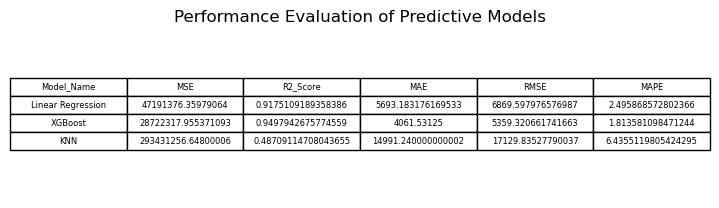

In [28]:
fig, ax = plt.subplots(figsize=(10, 2))  # Set the size as needed

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=Model_perf.values, colLabels=Model_perf.columns, cellLoc='center', loc='center')

# Add a title
plt.title('Performance Evaluation of Predictive Models')

# Adjust layout
plt.subplots_adjust(left=0.2, top=0.95)

# Display the table
plt.show()

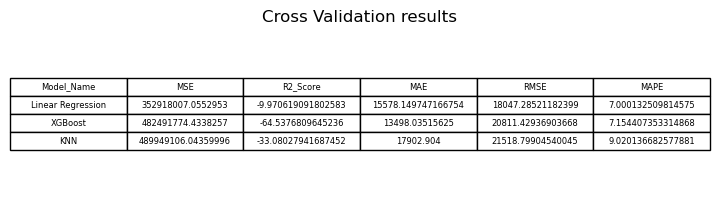

In [29]:
fig, ax = plt.subplots(figsize=(10, 2))  # Set the size as needed

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=Cross_val_perf.values, colLabels=Model_perf.columns, cellLoc='center', loc='center')

# Add a title
plt.title('Cross Validation results')
s
# Adjust layout
plt.subplots_adjust(left=0.2, top=0.95)

# Display the table
plt.show()

In [89]:
Cross_val_perf

,Model_Name,MSE,R2_Score,MAE,RMSE,MAPE
0,Linear Regression,4.155391e+08,0.170834,16758.298144,18966.310700,7.602415
1,XGBoost,5.527699e+08,-0.132085,15481.745573,21449.729686,7.713542
2,KNN,3.634009e+08,0.270465,13775.181667,18894.272229,7.220279


In [14]:
Model_perf2

,Model_Name,MSE,R2_Score,MAE,RMSE,MAPE
0,Linear Regression,2.090523e+08,0.634583,10603.209665,14458.639624,4.542748
1,XGBoost,1.284290e+08,0.775510,6942.637500,11332.653561,2.879102
2,KNN,2.688304e+08,0.530093,13448.040000,16396.049340,5.846778


In [15]:
Model_perf

,Model_Name,MSE,R2_Score,MAE,RMSE,MAPE
0,Linear Regression,4.719138e+07,0.917511,5693.183176,6869.597977,2.495869
1,XGBoost,2.872232e+07,0.949794,4061.531250,5359.320662,1.813581
2,KNN,2.934313e+08,0.487091,14991.240000,17129.835278,6.435512
